### Import Dependencies

In [1]:
# statistical analysis
import pandas as pd
import numpy as np

# database interaction
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import MetaData, Table, Column, Integer, String, Date, ForeignKey
from sqlalchemy.orm import Session, relationship, mapper
from sqlalchemy import create_engine

# Load configuration
from config import DATABASE_URI

### Database Setup

In [2]:
# create a database connection
engine = create_engine(DATABASE_URI)

In [3]:
# connect to database
con = engine.connect()

In [4]:
# create MetaData object
metadata = MetaData()

In [5]:
# reflect an existing database into a new model
Model = automap_base(metadata=metadata)

In [6]:
# create python classes by extending the existing database models
# use a nicer representation of the class instances

class Employee(Model):
    __tablename__ = 'employees'
    
    def __repr__(self):
        return "<{}(emp_no='{}', first_name='{}', last_name='{}', birth_date='{}', gender='{}', hire_date='{}')>"\
                .format(self.__class__.__name__, self.emp_no, self.first_name, self.last_name, self.birth_date, self.gender, self.hire_date)

class Department(Model):
    __tablename__ = 'departments'
    
    def __repr__(self):
        return "<{}(dept_no='{}', dept_name='{}')>".format(self.__class__.__name__, self.dept_no, self.dept_name)

        
class DeptEmp(Model):
    __tablename__ = 'dept_emp'
    
    def __repr__(self):
        return "<{}(emp_no='{}', dept_no='{}', from_date='{}', to_date='{}')>"\
                .format(self.__class__.__name__, self.emp_no, self.dept_no, self.from_date, self.to_date)
    
class DeptMgr(Model):
    __tablename__ = 'dept_manager'
    
    def __repr__(self):
        return "<{}(dept_no='{}', emp_no='{}', from_date='{}', to_date='{}')>"\
                .format(self.__class__.__name__, self.dept_no, self.emp_no, self.from_date, self.to_date)

class Salary(Model):
    __tablename__ = 'salaries'
    emp_no = Column(Integer, ForeignKey('employees.emp_no'), primary_key=True, nullable=False)
    
    def __repr__(self):
        return "<{}(emp_no='{}', salary='{}', from_date='{}', to_date='{}')>"\
                .format(self.__class__.__name__, self.emp_no, self.salary, self.from_date, self.to_date)
    
class Title(Model):
    __tablename__ = 'titles'
    
    def __repr__(self):
        return "<{}(emp_no='{}', title='{}', from_date='{}', to_date='{}')>"\
                .format(self.__class__.__name__, self.emp_no, self.title, self.from_date, self.to_date)

# create view schema
empdeptdate = Table('emp_dept_date', metadata, 
                    Column('emp_no', Integer, ForeignKey('employees.emp_no'), primary_key=True, nullable=False), 
                    autoload_with=engine)

# create view ORM class
class EmpDeptDate(object):
    __tablename__ = 'emp_dept_date'
    emp_no = Column(Integer, ForeignKey('employees.emp_no'), primary_key=True, nullable=False)
    
    def __repr__(self):
        return "<{}(emp_no='{}', date='{}')>"\
                .format(self.__class__.__name__, self.emp_no, self.date)

# associate the view schema with the ORM class
mapper(EmpDeptDate, empdeptdate)

# create view schema
emptitle = Table('emp_title', metadata,
                 Column('emp_no', Integer, ForeignKey('employees.emp_no'), primary_key=True, nullable=False), 
                 autoload_with=engine)

# create view ORM class
class EmpTitle(object):
    __tablename__ = 'emp_title'
    emp_no = Column(Integer, ForeignKey('employees.emp_no'), primary_key=True, nullable=False)
    
    def __repr__(self):
        return "<{}(emp_no='{}', date='{}')>"\
                .format(self.__class__.__name__, self.emp_no, self.date)

# associate the view schema with the ORM class
mapper(EmpTitle, emptitle)
print()

<Mapper at 0x118b28350; EmpTitle>

In [7]:
# use the Model class to reflect the database tables into ORM classes
Model.prepare(engine, reflect=True)

In [8]:
# create database session
session = Session(engine)

### Loading DataFrame Using SQLAlchemy
( is much slower than using a SQL query directly with pandas )

In [9]:
# use the session to query the database and create a pandas dataframe
df = pd.DataFrame([ (row.Employee.emp_no, row.Employee.last_name,row.Employee.first_name,row.Title.title,row.Department.dept_name,row.Salary.salary,row.Salary.from_date,row.Salary.to_date) for row in session.query(DeptEmp, Employee, Department, Salary, Title).\
    join(Employee, Employee.emp_no == DeptEmp.emp_no).\
    join(Department, Department.dept_no == DeptEmp.dept_no).\
    join(Salary, Salary.emp_no == DeptEmp.emp_no).\
    join(EmpDeptDate, EmpDeptDate.emp_no == DeptEmp.emp_no).\
    join(Title, Title.emp_no == DeptEmp.emp_no).\
    join(EmpTitle, EmpTitle.emp_no == Title.emp_no).\
    filter(EmpDeptDate.date == DeptEmp.to_date).\
    filter(EmpTitle.date == Title.to_date).\
    all() ], columns=['employee_no','last_name', 'first_name', 'title', 'department', 'salary', 'start_date', 'end_date'])

In [10]:
print(df.shape)
df.head()

(300033, 8)


,employee_no,last_name,first_name,title,department,salary,start_date,end_date
0,10001,Facello,Georgi,Senior Engineer,Development,60117,1986-06-26,1987-06-26
1,10004,Koblick,Chirstian,Senior Engineer,Production,40054,1986-12-01,1987-12-01
2,10008,Kalloufi,Saniya,Assistant Engineer,Development,46671,1998-03-11,1999-03-11
3,10012,Bridgland,Patricio,Senior Engineer,Development,40000,1992-12-18,1993-12-18
4,10015,Nooteboom,Guoxiang,Senior Staff,Research,40000,1992-09-19,1993-08-22


In [12]:
# check if there are any employee records returned
df['employee_no'].duplicated().any()

True

In [15]:
# check if there are any null values
df.isnull().sum(axis=0)

employee_no    0
last_name      0
first_name     0
title          0
department     0
salary         0
start_date     0
end_date       0
dtype: int64

### Loading DataFrame Using SQL
( is faster than SQLAlchemy query and joins )

In [74]:
# create a SQL query to use for loading pandas dataframe
query = """
        SELECT 
            e.emp_no employee_no,
            e.last_name last_name,
            e.first_name first_name,
            t.title title,
            d.dept_name department,
            s.salary salary,
            s.from_date start_date,
            s.to_date end_date
        FROM dept_emp de
        INNER JOIN employees e on e.emp_no = de.emp_no
        INNER JOIN departments d on d.dept_no = de.dept_no
        INNER JOIN salaries s on s.emp_no = de.emp_no
        INNER JOIN emp_dept_date edd ON edd.emp_no = de.emp_no AND edd.date = de.to_date
        INNER JOIN titles t ON t.emp_no = de.emp_no
        INNER JOIN emp_title et ON et.emp_no = de.emp_no AND et.date = t.to_date
        ;
        """

In [75]:
# return query results as pandas dataframe
df = pd.read_sql_query(query, con)

In [76]:
# check dataframe
print(df.shape)
df.head()

(300033, 8)


,employee_no,last_name,first_name,title,department,salary,start_date,end_date
0,10002,Simmel,Bezalel,Staff,Sales,65828.0,1996-08-03,1997-08-03
1,10001,Facello,Georgi,Senior Engineer,Development,60117.0,1986-06-26,1987-06-26
2,10004,Koblick,Chirstian,Senior Engineer,Production,40054.0,1986-12-01,1987-12-01
3,10008,Kalloufi,Saniya,Assistant Engineer,Development,46671.0,1998-03-11,1999-03-11
4,10012,Bridgland,Patricio,Senior Engineer,Development,40000.0,1992-12-18,1993-12-18


In [106]:
# figure out the lowest and highest salaries
print(f'Maximum Salary: {df["salary"].max()}')
print(f'Lowest Salary: {df["salary"].min()}')

Maximum Salary: 129492.0
Lowest Salary: 40000.0


In [111]:
# create the bins in which the data will be held
bins = [0, 39999, 59999, 79999, 99999, 119999, 130000]

# create labels for these bins
labels = ["0 to 39k", "40k to 59k", "60k to 79k", "80k to 99k", "100k to 119k", "120k to 130k"]

In [113]:
# slice the salaries and place it into bins
df['salary_group'] = pd.cut(df['salary'], bins, labels=labels)

In [140]:
# analyze salary ranges by title
df.groupby(['title','salary_group'])['salary'].count()

title               salary_group
Assistant Engineer  0 to 39k            0
                    40k to 59k       4950
                    60k to 79k        824
                    80k to 99k         61
                    100k to 119k        0
                    120k to 130k        0
Engineer            0 to 39k            0
                    40k to 59k      40040
                    60k to 79k       6828
                    80k to 99k        436
                    100k to 119k        3
                    120k to 130k        0
Manager             0 to 39k            0
                    40k to 59k          7
                    60k to 79k          2
                    80k to 99k          0
                    100k to 119k        0
                    120k to 130k        0
Senior Engineer     0 to 39k            0
                    40k to 59k      82988
                    60k to 79k      13879
                    80k to 99k        872
                    100k to 119k        8
 

In [115]:
# create groupby object based on 'salary_group'
salary_groups = df.groupby('salary_group')

In [141]:
# find how many employees fall into each bin
salary_groups['employee_no'].count()

salary_group
0 to 39k             0
40k to 59k      216387
60k to 79k       66228
80k to 99k       16130
100k to 119k      1264
120k to 130k        24
Name: employee_no, dtype: int64

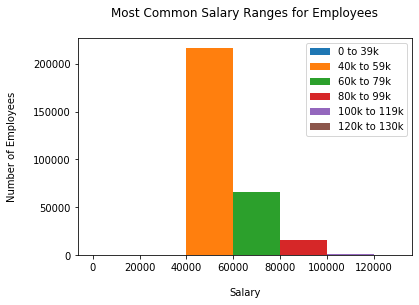

In [158]:
# create a histogram to visualize the most common salary ranges for employees.
ax = salary_groups['salary'].plot.hist(bins=bins)

plt.title('Most Common Salary Ranges for Employees\n')
plt.ylabel('Number of Employees\n')
plt.xlabel('\nSalary')
plt.legend(loc='best')

plt.show()

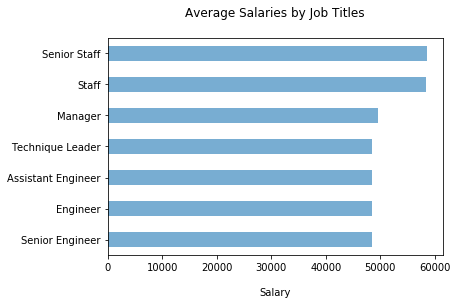

In [26]:
# generate a horizontal bar plot
ax = df.groupby('title')['salary'].mean().sort_values().plot.barh(x='title', y='salary', alpha=0.6)
ax.set_title('Average Salaries by Job Titles\n')
ax.set_ylabel('')
ax.set_xlabel('\nSalary')
ax.set_xlim((0,df.groupby('title')['salary'].mean().max()+(df.groupby('title')['salary'].mean().max()*.05)))

plt.show()

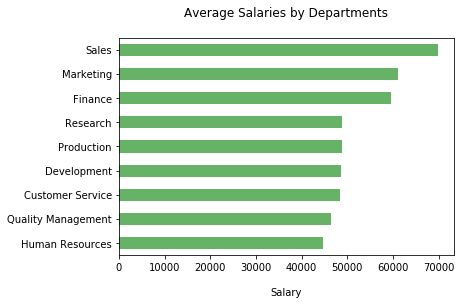

In [58]:
# generate a horizontal bar plot
ax = df.groupby('department')['salary'].mean().sort_values().plot.barh(x='department', y='salary', colormap='ocean', alpha=.6)
ax.set_title('Average Salaries by Departments\n')
ax.set_ylabel('')
ax.set_xlabel('\nSalary')
ax.set_xlim((0,df.groupby('department')['salary'].mean().max()+(df.groupby('department')['salary'].mean().max()*.05)))

plt.show()